# Financial Analytics - TP Final
## Integrantes: 
### - *Franco Ferrari*
### - *Aldo Escobar*
### - *Damian Izanotegui*
### - *Nahuel Sanchez*

## Analisis Exploratorio

Cargamos los datasets, computamos las medias móbiles, y ploteamos la apariencia inicial del dataset

In [25]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [36]:
# Imports
import pandas as pd
import yfinance as yf
import numpy as np
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
import numba as nb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, roc_auc_score

import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from notebooks.mlfinlab.corefns.core_functions import CoreFunctions
from notebooks.mlfinlab.corefns.financial_functions import FinancialFunctions
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Functions

#Cargamos ambos files y los unimos, usando como indices en ambos las fechas.
def load_and_join():
    mtum = yf.Ticker("MTUM")
    stocks = ["MTUM"]
    start = datetime.datetime(2000,11,30)
    end = datetime.datetime(2019,11,30)
    
    yf.pdr_override()
    
    df_etf = pdr.get_data_yahoo(stocks, start=start, end=end)
    
    df = pd.read_excel('https://images.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Century-of-Factor-Premia-Monthly.xlsx',
                      header =18, nrows = 1220)
    
    df['Date'] =  pd.to_datetime(df['Date'])
    
    
    df = df.set_index('Date')
    df = df[['Equity indices Value','Equity indices Momentum','Equity indices Carry','Equity indices Defensive']]
    
    df_final = df_etf.merge(df, how='left',left_index=True,right_index=True)
    
    return df_final

#Extendemos los datos mensuales a los registros diarios. (Ejemplo: todos los datos de enero, tomaran el valor monthly del 31/01)
def fill_joined_missing_fields(df):
    for i in range(1,len(df)+1):
        if np.isnan(df.iloc[-i,9]):
                df.iloc[-i,6] = df.iloc[-i+1,6]
                df.iloc[-i,7] = df.iloc[-i+1,7]
                df.iloc[-i,8] = df.iloc[-i+1,8]
                df.iloc[-i,9] = df.iloc[-i+1,9]
         

#Introducimos labels al dataset, calculando medias 50 y 200 dias.  
def labeling_df(df):
    df['50_days_average'] = df.iloc[:,3].rolling(window=10).mean()
    df['200_days_average'] = df.iloc[:,3].rolling(window=30).mean()
    df.loc[df['50_days_average'] >= df['200_days_average'], 'Buy/Sell'] = -1 #Si la media de corto plazo supera a la de largo, es posicion de sell
    df.loc[df['50_days_average'] < df['200_days_average'], 'Buy/Sell'] = 1 #Si la media de corto plazo esta por debajo de la de largo, es posicion de buy
    return df
 
#Visualizacion de la evolucion de precios y las medias.
def visualize_close_50_200(df):
    trace0 = go.Scatter(
    x = df.index,
    y = df.Close,
    name = 'Close',
    line = dict(
        color = 'grey',
        width = 2)
    )
    trace1 = go.Scatter(
        x = df.index,
        y = df['50_days_average'],
        name = '50_days_average',
        line = dict(
            color = "red",
            width = 2)
    )
    trace2 = go.Scatter(
        x = df.index,
        y = df['200_days_average'],
        name = '200_days_average',
        line = dict(
            color = "green",
            width = 2)
    )

    data = [trace0, trace1, trace2]

    # Edit the layout
    layout = dict(title = 'Evolution of MTUM ETF over time',
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'MTUM ETF'),
                  )

    fig = dict(data=data, layout=layout)
    iplot(fig)

def timeseries_train_test_split(X, y, test_size):
    """
        train test segun un esquema para series de tiempo
    """
    
    # tomamos el indice en donde empieza el test
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


# Defines a meta_label to represent if the signal was correct. (e.g. if the label was 1 (long), price raised on the next bar)
def meta_labeling(df,signal_column):
    new_df = df.copy().reset_index()
    new_df['Meta_Label'] = ''
    new_df = new_df.astype({signal_column:'int64'})
    for i in list(new_df.index):
        if i == new_df.index[-1]:
            break;
        if new_df.loc[i,signal_column] == 1: #Long Signal
            if new_df.loc[i,'Close'] <= new_df.loc[i+1,'Close']:
                new_df.loc[i,'Meta_Label'] = 1 #Next price is higher or same, take the bet.
            else:
                new_df.loc[i,'Meta_Label'] = 0 #Next price is lower, do not take the bet.
                
        elif new_df.loc[i,signal_column] == -1: #Short Signal
            if new_df.loc[i,'Close'] < new_df.loc[i+1,'Close']:
                new_df.loc[i,'Meta_Label'] = 0 #Next price is higher, do not take the bet.
            else:
                new_df.loc[i,'Meta_Label'] = 1 #Next price is lower or same, take the bet.    
    # new_df = new_df.astype({'Meta_Label':'int64'})
    return new_df


dataset = load_and_join()
fill_joined_missing_fields(dataset)

[*********************100%***********************]  1 of 1 completed


In [132]:
df = dataset.copy()

#Ploteando series
df = labeling_df(df)
visualize_close_50_200(df)

/home/aldo/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/semaphore_tracker.py:74: UserWarning:

semaphore_tracker: process died unexpectedly, relaunching.  Some semaphores might leak.



## Meta-Labeling

< Introducir Notas >

In [204]:
df_dropped = df.copy().iloc[200:].dropna()
df_aux = meta_labeling(df_dropped,'Buy/Sell')[:-1]
df_aux.set_index("Date", inplace = True)
df_aux.Meta_Label = df_aux.Meta_Label.astype(int)
X = df_aux.iloc[:,:13]
y = df_aux.iloc[:,13:]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [209]:
y_train.Meta_Label.value_counts()

0    526
1    500
Name: Meta_Label, dtype: int64

In [210]:
y_test.Meta_Label.value_counts()

0    233
1    208
Name: Meta_Label, dtype: int64

In [201]:
n_estimator = 10000
rf = RandomForestClassifier(verbose=1);
rf.fit(X_train, y_train);

/home/aldo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [126]:
from ipywidgets import IntProgress
from tpot import TPOTClassifier

X = df_aux.iloc[:,:13]
y = df_aux.iloc[:,13:]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)


#note mutation_rate + crossover_rate cannot exceed 1.0.
#mutation_rate=0.9,
#crossover_rate=,
#POPULATION_SIZE + GENERATIONS x OFFSPRING_SIZE
                   
tpot = TPOTClassifier(generations=20, 
                      population_size=50, 
                      offspring_size=50,
                      scoring = 'roc_auc',
                      cv = 5,
                      max_time_mins = 30,
                      max_eval_time_mins = 5, #default is 5min
                      n_jobs=1,
                      random_state = 42,
                      verbosity=2)
tpot.fit(X_train, y_train)
print("Accuracy is {}%".format(tpot.score(X_test, y_test)*100))

/home/aldo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Generation 1 - Current best internal CV score: 0.5850912848158132
Generation 2 - Current best internal CV score: 0.5850912848158132
Generation 3 - Current best internal CV score: 0.5850912848158132
Generation 4 - Current best internal CV score: 0.5850912848158132
Generation 5 - Current best internal CV score: 0.5850912848158132
Generation 6 - Current best internal CV score: 0.5851293800539084
Generation 7 - Current best internal CV score: 0.5851293800539084
Generation 8 - Current best internal CV score: 0.5852235399820305
Generation 9 - Current best internal CV score: 0.5853202156334232
Generation 10 - Current best internal CV score: 0.5853202156334232
Generation 11 - Current best internal CV score: 0.5854722371967653
Generation 12 - Current best internal CV score: 0.5855484276729559
Generation 13 - Current best internal CV score: 0.5855484276729559
Generation 14 - Current best internal CV score: 0.5857389038634322
Generation 15 - Current best internal CV score: 0.5857769991015275
Gene

/home/aldo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
tpot.

              precision    recall  f1-score   support

           0       0.53      1.00      0.69       233
           1       0.00      0.00      0.00       208

    accuracy                           0.53       441
   macro avg       0.26      0.50      0.35       441
weighted avg       0.28      0.53      0.37       441



/home/aldo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



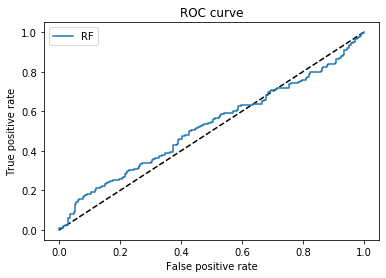

auc: 0.5


In [128]:
def plotROC(rf):
    y_pred_rf = rf.predict_proba(X_test)[:, 1]
    y_pred = rf.predict(X_test)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
    print(classification_report(y_test, y_pred))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    auc = roc_auc_score(y_true = y_test, y_score = y_pred)
    print(f"auc: {auc}")
    
plotROC(tpot)

## Diferenciacion fraccionaria

Encontramos que el mejor orden de diferenciación es 0.05

In [ ]:
#Consigue los weights para la diferenciacion!
def getWeights_FFD(d,size):
    w=[1.]
    for k in range(1,size):
        w_=-w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

#Funcion aux para pesos de FFD
def plotWeights(dRange,nPlots,size):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0],dRange[1],nPlots):
        w_=getWeights_FFD(d,size=size)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
        w=w.join(w_,how='outer')
    ax=w.plot()
    ax.legend(loc='upper right');plt.show()
    return

#Diferenciamos la serie! d es el orden de diferenciacion. "Thres" (threshold) maneja la acceptabilidad de las exclusiones. No modificar.
#to do
def fracDiff(series,d,thres=0.01):

    w=getWeights_FFD(d,series.shape[0])

    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]

    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]

            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

#Funcion para buscar el mejor d
def plotMinFFD(df):
    from statsmodels.tsa.stattools import adfuller
    import numpy.ma as ma
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    for d in np.linspace(0,1,21):
        df1=np.log(df[['Close']]).resample('1D').last() # Pasar a observaciones diarias
        df2=fracDiff(df1,d,thres=.01)
        corr = ma.corrcoef(ma.masked_invalid(df1.loc[df2.index,'Close']), ma.masked_invalid(df2['Close']))[0,1]
        df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # Aportar valores criticos
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    plt.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    plt.show()
    return out

#Diferenciacion fraccionaria: Buscando el mejor d, d* = 0.1
plt.figure(1)
out = plotMinFFD(dataset)

#Usando la diferenciacion con d = 0.05
df_ffd = fracDiff(dataset,0.05)  

## Sample Weights

Extraemos pesos por retorno y por tiempo.

In [ ]:
#Obtiene los factores por retorno para restar importancia a las observaciones.
def return_weight(df,price_column):
    returns = []
    price_array = list(df[price_column])
    for i in range(len(price_array)):
        if i != (len(price_array)-1):
            returns.append(abs(price_array[i+1]-price_array[i]))
    weights = []
    max_return = max(returns)
    for i in range(len(returns)):
        weights.append(returns[i]/max_return)
    return weights

#Obtiene los factores de tiempo para restar importancia a las obs]ervaciones.
def getTimeDecay(tW,clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0:slope=(1.-clfLastW)/clfW.iloc[-1]
    else:slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    return clfW

#Combina multiplicativamente ambos pesos para llegara a ponderadores finales.
def final_weight(df,price_column,factor):
    return_weights = return_weight(df,price_column)
    time_weights = list(getTimeDecay(df[price_column], clfLastW=factor))[:-1]
    model_weight = []
    for i in range(len(return_weights)):
        model_weight.append(return_weights[i]*time_weights[i])
    max_w = max(model_weight)
    final_weights = []
    for i in range(len(model_weight)):
        final_weights.append(model_weight[i]/max_w)            
    return final_weights

model_weights = final_weight(dataset,'close',0)

In [145]:
for train, test in kf.split(X_train):
    print(train)
    print(test)

[ 206  207  208  209  210  211  212  213  214  215  216  217  218  219
  220  221  222  223  224  225  226  227  228  229  230  231  232  233
  234  235  236  237  238  239  240  241  242  243  244  245  246  247
  248  249  250  251  252  253  254  255  256  257  258  259  260  261
  262  263  264  265  266  267  268  269  270  271  272  273  274  275
  276  277  278  279  280  281  282  283  284  285  286  287  288  289
  290  291  292  293  294  295  296  297  298  299  300  301  302  303
  304  305  306  307  308  309  310  311  312  313  314  315  316  317
  318  319  320  321  322  323  324  325  326  327  328  329  330  331
  332  333  334  335  336  337  338  339  340  341  342  343  344  345
  346  347  348  349  350  351  352  353  354  355  356  357  358  359
  360  361  362  363  364  365  366  367  368  369  370  371  372  373
  374  375  376  377  378  379  380  381  382  383  384  385  386  387
  388  389  390  391  392  393  394  395  396  397  398  399  400  401
  402 

## Cross Validation

< Introducir Notas >

In [280]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train_copy = X_train.reset_index(drop=False)
y_train_copy = y_train.reset_index(drop=False)

for train, test in kf.split(X_train_copy):
    #print(train)
    #print(test)
    train = list(train)
    # Embargo de 4 días
    #Si Test esta al inicio
    if test[0] == 0:
        del train[:4]
        x_train_aux = X_train_copy[X_train_copy.index.isin(train)].copy()
        x_test_aux = X_train_copy[X_train_copy.index.isin(test)].copy()
        y_train_aux = y_train_copy[y_train_copy.index.isin(train)].copy()
        y_test_aux = y_train_copy[y_train_copy.index.isin(test)].copy()
        #X_train3, X_test3 = X['var'][train], X['var'][test]
        ##print(train)
        #print(test)
        
    #Si test esta al final    
    elif test[-1] == len(X)-1:
        del train[-4:]
        x_train_aux = X_train_copy[X_train_copy.index.isin(train)].copy()
        x_test_aux = X_train_copy[X_train_copy.index.isin(test)].copy()
        y_train_aux = y_train_copy[y_train_copy.index.isin(train)].copy()
        y_test_aux = y_train_copy[y_train_copy.index.isin(test)].copy()
        #X_train3, X_test3 = X['var'][train], X['var'][test]
        #print(train)
        ###print(test)
        
    #Si test está en el medio    
    else:
        lista = list(range(test[0]-4,test[0]+1))
        lista.extend(list(range(test[-1]+1,test[-1]+5)))
        train = list(filter(lambda x: (x not in lista) , train))
        x_train_aux = X_train_copy[X_train_copy.index.isin(train)].copy()
        x_test_aux = X_train_copy[X_train_copy.index.isin(test)].copy()
        y_train_aux = y_train_copy[y_train_copy.index.isin(train)].copy()
        y_test_aux = y_train_copy[y_train_copy.index.isin(test)].copy()
        #X_train3, X_test3 = X['var'][train], X['var'][test]
        #print(train)
        #print(test)
    x_train_aux = x_train_aux.drop(['Date'], axis=1)
    y_train_aux = y_train_aux.drop(['Date'], axis=1)
    x_test_aux = x_test_aux.drop(['Date'], axis=1)
    y_test_aux= y_test_aux.drop(['Date'], axis=1)
    rf.fit(x_train_aux, y_train_aux)
    y_predict = rf.predict_proba(x_test_aux)
    x_test_aux['Bet_Size'] = y_predict[:,1]
    back_test(x_test_aux,mode='Simple')
    back_test(x_test_aux,mode='BetS')

/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Paralle

Modo Simple!
Rate of Return: 19.40%
Modo via señales y bet sizing!
Portfolio result: 11.85%
Trade quantity: 10
Ratio of Longs: 50.00%
Sharpe Ratio: 4.495
0.1185151943778233 0.026368192844048677


Modo Simple!
Rate of Return: 3.60%
Modo via señales y bet sizing!
Portfolio result: 10.25%
Trade quantity: 13
Ratio of Longs: 46.15%
Sharpe Ratio: 8.007
0.10249566856195187 0.012800113154499141


Modo Simple!
Rate of Return: 9.27%
Modo via señales y bet sizing!
Portfolio result: 0.54%
Trade quantity: 9
Ratio of Longs: 55.56%
Sharpe Ratio: 0.320
0.00541674732163599 0.016935093403678728


Modo Simple!
Rate of Return: 9.58%
Modo via señales y bet sizing!
Portfolio result: 0.29%
Trade quantity: 4
Ratio of Longs: 50.00%
Sharpe Ratio: 0.723
0.002876321694985335 0.003978899332727401


Modo Simple!
Rate of Return: 28.86%
Modo via señales y bet sizing!
Portfolio result: -2.98%
Trade quantity: 8
Ratio of Longs: 50.00%
Sharpe Ratio: -1.674
-0.029841369554144778 0.017827101206742017




/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Paralle

In [263]:
x_test_aux

,Open,High,Low,Close,Adj Close,Volume,Equity indices Value,Equity indices Momentum,Equity indices Carry,Equity indices Defensive,50_days_average,200_days_average,Buy/Sell,Bet_Size
0,58.680000,58.680000,57.040001,57.070000,52.933750,25700,0.009686,0.017486,-0.005122,0.039655,58.982000,59.613000,1,0.5
1,57.410000,57.810001,57.160000,57.680000,53.499538,16500,0.009686,0.017486,-0.005122,0.039655,58.691999,59.558333,1,0.4
2,57.549999,57.709999,56.730000,57.500000,53.332588,19700,0.009686,0.017486,-0.005122,0.039655,58.355999,59.485333,1,0.5
3,57.630001,58.180000,57.630001,58.169998,53.954021,4000,0.009686,0.017486,-0.005122,0.039655,58.155999,59.433000,1,0.4
4,58.599998,59.410000,58.599998,59.410000,55.104160,4100,0.009686,0.017486,-0.005122,0.039655,58.230000,59.419333,1,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,67.330002,67.839996,67.330002,67.769997,63.329548,14900,-0.006760,0.024152,-0.027910,0.019820,67.000999,64.778333,-1,0.2
202,67.480003,67.610001,67.300003,67.480003,63.058563,64900,-0.006760,0.024152,-0.027910,0.019820,67.080999,64.868000,-1,0.4
203,67.349998,67.589996,67.129997,67.430000,63.011829,29000,-0.006760,0.024152,-0.027910,0.019820,67.120999,65.007333,-1,0.2
204,68.129997,68.129997,67.690002,67.800003,63.357601,27900,-0.006760,0.024152,-0.027910,0.019820,67.225999,65.189666,-1,0.4


In [256]:
x_test_aux

,Open,High,Low,Close,Adj Close,Volume,Equity indices Value,Equity indices Momentum,Equity indices Carry,Equity indices Defensive,50_days_average,200_days_average,Buy/Sell
0,58.680000,58.680000,57.040001,57.070000,52.933750,25700,0.009686,0.017486,-0.005122,0.039655,58.982000,59.613000,1
1,57.410000,57.810001,57.160000,57.680000,53.499538,16500,0.009686,0.017486,-0.005122,0.039655,58.691999,59.558333,1
2,57.549999,57.709999,56.730000,57.500000,53.332588,19700,0.009686,0.017486,-0.005122,0.039655,58.355999,59.485333,1
3,57.630001,58.180000,57.630001,58.169998,53.954021,4000,0.009686,0.017486,-0.005122,0.039655,58.155999,59.433000,1
4,58.599998,59.410000,58.599998,59.410000,55.104160,4100,0.009686,0.017486,-0.005122,0.039655,58.230000,59.419333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,67.330002,67.839996,67.330002,67.769997,63.329548,14900,-0.006760,0.024152,-0.027910,0.019820,67.000999,64.778333,-1
202,67.480003,67.610001,67.300003,67.480003,63.058563,64900,-0.006760,0.024152,-0.027910,0.019820,67.080999,64.868000,-1
203,67.349998,67.589996,67.129997,67.430000,63.011829,29000,-0.006760,0.024152,-0.027910,0.019820,67.120999,65.007333,-1
204,68.129997,68.129997,67.690002,67.800003,63.357601,27900,-0.006760,0.024152,-0.027910,0.019820,67.225999,65.189666,-1


In [224]:
y_train_aux

,Meta_Label
0,1
1,0
2,1
3,1
4,1
...,...
812,1
813,0
814,0
815,0


In [178]:
y_test_aux

,Meta_Label
Date,
2018-03-01,0
2018-03-02,0
2018-03-05,0
2018-03-06,0
2018-03-07,0
...,...
2018-12-17,1
2018-12-18,0
2018-12-19,0


In [157]:
y_train_aux.set_index("Date", inplace = False)

,Open,High,Low,Close,Adj Close,Volume,Equity indices Value,Equity indices Momentum,Equity indices Carry,Equity indices Defensive,50_days_average,200_days_average,Buy/Sell
Date,,,,,,,,,,,,,
2018-03-01,110.120003,110.419998,107.180000,108.010002,105.097565,1366400,0.011670,0.005214,-0.010041,-0.002058,109.822001,109.345001,-1
2018-03-02,106.730003,108.639999,106.099998,108.360001,105.438126,956600,0.011670,0.005214,-0.010041,-0.002058,109.704001,109.273334,-1
2018-03-05,107.790001,109.970001,107.349998,109.650002,106.693336,504700,0.011670,0.005214,-0.010041,-0.002058,109.726001,109.223001,-1
2018-03-06,110.230003,110.250000,109.239998,109.970001,107.004707,463700,0.011670,0.005214,-0.010041,-0.002058,109.782001,109.160667,-1
2018-03-07,108.970001,110.489998,108.650002,110.230003,107.257698,720100,0.011670,0.005214,-0.010041,-0.002058,109.916001,109.102334,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-21,122.779999,122.779999,121.910004,122.070000,121.573059,603100,-0.029074,0.038236,-0.003343,0.024068,121.823000,120.014000,-1
2019-11-22,122.360001,122.360001,121.699997,122.169998,121.672653,561400,-0.029074,0.038236,-0.003343,0.024068,121.996000,120.123667,-1
2019-11-25,122.669998,123.110001,122.309998,123.019997,122.519188,385000,-0.029074,0.038236,-0.003343,0.024068,122.246000,120.268667,-1


In [140]:
kf??

## Feature Importance

< Introducir Notas >

In [ ]:
#TODO: mejorar graficas, mattplotlib sos muy feo
def plotImportance(rf):
    # Feature Importance
    title = 'Feature Importance:'
    figsize = (15, 5)

    feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
    feat_imp['feature'] = X.columns
    feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
    feat_imp = feat_imp

    feat_imp.sort_values(by='Importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
plotImportance(rf)

## Backtesting

Calculamos:
1. Retorno del Portfolio
2. Trades Realizados
3. Ratio of Longs
4. Sharpe Ratio

In [279]:
def back_test(df,mode, risk_free = 0.0):
    # df1 = df.loc[start_date:end_date]
    df1 = df
    ''' Modos disponibles:
        1- 'Simple' -> Simple: Toma la performance de una estrategia "Buy and Hold". Compra en t=1, vende en t=T (Ultimo dia)
        2- 'Signal' -> Señal: Compra y vende segun el campo 'Buy/Sell'. Size es 1 siempre.
        3- 'BetS' -> Bet Sizing: Usa la señal del campo Buy/Sell y la pondera por la probabilizada del campo 'BetSize'. '''
        
    if mode == 'Simple':
        print('Modo Simple!')
        opening_price = df1['Close'].iloc[0]
        closing_price = df1['Close'].iloc[-1]
        result = (closing_price - opening_price) / opening_price
        # print('Opening Price: $ {:.2f}'.format(opening_price))
        # print('Closing Price: $ {:.2f}'.format(closing_price))
        print('Rate of Return: {:.2%}'.format(result))
        trades = pd.DataFrame()
        return result
        
    elif mode == 'Signal':
        print('Modo via señales!')
        trades = pd.DataFrame(columns=['Opening_Price','Closing_Price','Return','Type'])
        position = 0
        trade_count = 0
        long_count = 0
        for i in df1.index:
            if position == 0:
                position = df1.loc[i,'Buy/Sell']
                open_price = df1.loc[i,'Close']
            elif position == 1 and (df1.loc[i,'Buy/Sell'] == -1 or i == (len(df1)-1)):
                # Cambio de Buy a Sell
                result = (df1.loc[i,'Close'] - open_price) / open_price
                trades = trades.append({'Opening_Price':open_price,'Closing_Price':df1.loc[i,'Close'],'Return':result,'Type':'Long'}, ignore_index=True)
                open_price = df1.loc[i,'Close']
                trade_count += 1
                long_count += 1
                
            elif position == -1 and (df1.loc[i,'Buy/Sell'] == 1 or i == (len(df1)-1)):
                # Cambio de Sell a Buy
                result = (open_price - df1.loc[i,'Close']) / open_price
                trades = trades.append({'Opening_Price':open_price,'Closing_Price':df1.loc[i,'Close'],'Return':result,'Type':'Short'}, ignore_index=True)
                open_price = df1.loc[i,'Close']
                trade_count += 1
                
            position = df1.loc[i,'Buy/Sell']
        
        # print('*********** Trades ejecutados: **************')
        # print('*********************************************')
        # for i in range(len(trades)):
        #     print('Trade {}, tipo: {}'.format(i,trades.iloc[i,3]))
        #     print('Abrio al precio de $ {:.2f} y cerro en $ {:.2f}'.format(trades.iloc[i,0],trades.iloc[i,1]))
        #     print('Retorno: {:.2%}'.format(trades.iloc[i,2]))
        #     print('*********************************************')
        
        print('Portfolio result: {:.2%}'.format(trades['Return'].sum()))
        print('Trade quantity: {}'.format(trade_count))
        print('Ratio of Longs: {:.2%}'.format(long_count/trade_count))
        print('Sharpe Ratio: {:.3f}'.format((trades['Return'].sum()-risk_free)/trades['Return'].std()))
        print(trades['Return'].sum(),trades['Return'].std())
        print("\n")
        return (trades['Return'].sum(),((trades['Return'].sum()-risk_free)/trades['Return'].std()))
                                                 
    elif mode == 'BetS':
        print('Modo via señales y bet sizing!')
        trades = pd.DataFrame(columns=['Opening_Price','Closing_Price','Return','Type','Bet Size'])
        position = 0
        trade_count = 0
        long_count = 0
        for i in df1.index:
            if position == 0:
                position = df1.loc[i,'Buy/Sell']
                open_price = df1.loc[i,'Close']
                bet_size = df1.loc[i,'Bet_Size']
            elif position == 1 and (df1.loc[i,'Buy/Sell'] == -1 or i == (len(df1)-1)):
                # Cambio de Buy a Sell
                result = ((df1.loc[i,'Close'] - open_price) / open_price)*bet_size
                trades = trades.append({'Opening_Price':open_price,'Closing_Price':df1.loc[i,'Close'],'Return':result,'Type':'Long','Bet Size':bet_size}, ignore_index=True)
                open_price = df1.loc[i,'Close']
                trade_count += 1
                long_count += 1
                
            elif position == -1 and (df1.loc[i,'Buy/Sell'] == 1 or i == (len(df1)-1)):
                # Cambio de Sell a Buy
                result = ((open_price - df1.loc[i,'Close']) / open_price)*bet_size
                trades = trades.append({'Opening_Price':open_price,'Closing_Price':df1.loc[i,'Close'],'Return':result,'Type':'Short','Bet Size':bet_size}, ignore_index=True)
                open_price = df1.loc[i,'Close']
                trade_count += 1
                
                
            position = df1.loc[i,'Buy/Sell']
            bet_size = df1.loc[i,'Bet_Size']
        
        # print('*********** Trades ejecutados: **************')
        # print('*********************************************')
        # for i in range(len(trades)):
        #     print('Trade {}, tipo: {}'.format(i,trades.iloc[i,3]))
        #     print('Abrio al precio de $ {:.2f} y cerro en $ {:.2f}, con un size de {:.2f}'.format(trades.iloc[i,0],trades.iloc[i,1],trades.iloc[i,4]))
        #     print('Retorno: {:.2%}'.format(trades.iloc[i,2]))
        #     print('*********************************************')
        
        print('Portfolio result: {:.2%}'.format(trades['Return'].sum()))
        print('Trade quantity: {}'.format(trade_count))
        print('Ratio of Longs: {:.2%}'.format(long_count/trade_count))
        print('Sharpe Ratio: {:.3f}'.format((trades['Return'].sum()-risk_free)/trades['Return'].std()))
        print(trades['Return'].sum(),trades['Return'].std())
        print("\n")
        return (trades['Return'].sum(),((trades['Return'].sum()-risk_free)/trades['Return'].std()))
                
    else:
        print('Modo incorrecto!')
        return 0
            

In [ ]:
start_date = '2018-01-02'
end_date = '2020-01-02'
back_test(df,'Simple',start_date,end_date)
print('---------------------------------------')
# back_test(df,'Signal','2018-01-02','2019-01-02')
print('---------------------------------------')
back_test(df,'BetS',start_date,end_date)

## Conclusiones

< Introducir Notas >

In [ ]:
## Codigo